<a href="https://colab.research.google.com/github/Madhvi31/CanteenConnects/blob/main/jupyter_notebooks/speech_to_intent_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# // Installing all the necessary requirements
!pip install tensorflow~=2.18

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !gdown https://drive.google.com/uc?id=1di8A3zPfrbByBgUfhP1kJnzClKj0gZo5  #dataset
    !unzip --qq slu_data.zip
    !pip install audiomentations
    !sudo apt-get install xxd

Downloading...
From (original): https://drive.google.com/uc?id=1di8A3zPfrbByBgUfhP1kJnzClKj0gZo5
From (redirected): https://drive.google.com/uc?id=1di8A3zPfrbByBgUfhP1kJnzClKj0gZo5&confirm=t&uuid=0efcb4f9-13b1-47d2-a816-193df1859e84
To: /content/slu_data.zip
100% 1.56G/1.56G [00:20<00:00, 74.6MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xxd is already the newest version (2:8.2.3995-1ubuntu2.21).
xxd set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm

import io, base64
import os, sys
from datetime import datetime

import IPython
import pickle

from sklearn.utils import shuffle
import string

from tensorflow.keras.utils import Sequence

import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, AddBackgroundNoise, PitchShift, Shift, ClippingDistortion, Gain, LoudnessNormalization, TimeStretch
from tensorflow.python.ops import gen_audio_ops as contrib_audio

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Flatten, Activation, Add
from tensorflow.keras.layers import Dense, Dropout, Softmax, TimeDistributed, LSTM
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

from keras import backend as K

import random
import glob

from tensorflow.keras.models import load_model

import scipy.io.wavfile as wav

DEBUG = False

root_folder = '.' if IN_COLAB else ".."
project_path = os.path.join(root_folder, 'checkpoints')

train_dataset_path = os.path.join(root_folder, 'data/csv/train_data.csv')
valid_dataset_path = os.path.join(root_folder, 'data/csv/valid_data.csv')
#test_dataset_path = os.path.join(root_folder, 'data/csv/test_data.csv')
test_dataset_path = os.path.join(root_folder, 'data/csv/wt_data.csv')

SAMPLING_RATE = 16000
MIN_FREQ = 100
MAX_FREQ = SAMPLING_RATE//2
WIN_SIZE_MS = 0.02
WIN_INCREASE_MS = 0.02
NUM_CEPSTRAL = 10
EPOCH_NUM = 1

Let's open the test dataset and have a look at it's content.

In [5]:
test_data = pd.read_csv(test_dataset_path)
test_data.head()

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/wt_data/Bring_me_my_socks_325311.wav,NaN,Bring me my socks,bring,socks,none
1,1,wavs/wt_data/Bring_me_my_socks_872611.wav,NaN,Bring me my socks,bring,socks,none
2,2,wavs/wt_data/Bring_me_some_juice_147104.wav,NaN,Bring me some juice,bring,juice,none
3,3,wavs/wt_data/Bring_me_some_juice_184605.wav,NaN,Bring me some juice,bring,juice,none
4,4,wavs/wt_data/Bring_me_some_juice_336204.wav,NaN,Bring me some juice,bring,juice,none


For a quick dataset sanity check - especially useful if you are crearing the dataset yourself, let's listen to the first entry and make sure it matches the transcription.

In [6]:
prefix = [root_folder, "data"]
wav_file = os.path.join(*prefix, test_data['path'][0])
print(wav_file)
IPython.display.Audio(wav_file)

./data/wavs/wt_data/Bring_me_my_socks_325311.wav


In order to match MFCC processing parameters on device, we use audio_spectrogram and mfcc functions from Tensorflow gen_audio_ops. In generate_features function we create a spectrogram, convert it to mel frequency and (optionally) visualize it with matplotlib. In the next cell we run this process for the above .wav file.

{'type': 'spectrogram', 'shape': {'width': 10, 'height': 150}}


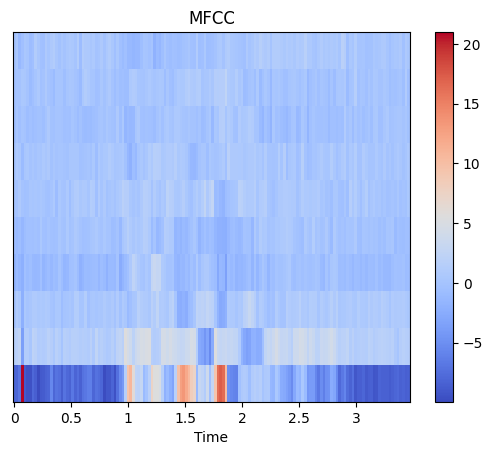

In [7]:
audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')

if DEBUG:
    print(wav_file)

def generate_features(draw_graphs, raw_data, sampling_freq,
                      frame_length, frame_stride, num_filters,
                      num_cepstral, low_frequency, high_frequency):
    graphs = []

    raw_data = np.expand_dims(raw_data, axis = -1)
    window_size = int(sampling_freq * frame_length)
    stride = int(sampling_freq * frame_stride)

    spectrogram = contrib_audio.audio_spectrogram(
        raw_data,
        window_size=window_size,
        stride=stride,
        magnitude_squared=True)

    mfcc = contrib_audio.mfcc(
        spectrogram,
        sampling_freq,
        dct_coefficient_count=num_cepstral,
        upper_frequency_limit=high_frequency,
        lower_frequency_limit=low_frequency)

    mfcc = np.squeeze(mfcc)

    if draw_graphs:
        mfcc_graph = np.swapaxes(mfcc, 0, 1)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mfcc_graph, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set(title='MFCC')
        buf = io.BytesIO()

        plt.savefig(buf, format='svg', bbox_inches='tight', pad_inches=0)

        buf.seek(0)
        image = (base64.b64encode(buf.getvalue()).decode('ascii'))

        buf.close()

        graphs.append({
            'name': 'Cepstral Coefficients',
            'image': image,
            'imageMimeType': 'image/svg+xml',
            'type': 'image'
        })

    return {
        'features': mfcc,
        'graphs': graphs,
        'output_config': {
            'type': 'spectrogram',
            'shape': {
                'width': mfcc.shape[1],
                'height': mfcc.shape[0]
            }
        }
    }

processed = generate_features(True, audio, SAMPLING_RATE,
                              WIN_SIZE_MS, WIN_INCREASE_MS, 32,
                              NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

if DEBUG:
    print(processed['features'])

print(processed['output_config'])

In the next cell we process the .csv file data into ground truth labels for the model. Slots include both words for objects and locations, while intents include only words for actions. During preprocessing we also create a common vocabulary, including all the words in transcriptions, slots and intents, but it is not used in training.
In order to ensure the consistency between runs, as long as you use the same dataset, it only necessary to create and save vectorized training/validation data and reverse dictionaries (for decoding) once.

In [8]:
class DatasetFactory:

    def __init__(self):
        self.actions = set()
        self.objects = set()
        self.locations = set()
        self.vocab = set()

    def get_query_slots(self, sentence):

        slots = [sentence[0], sentence[1]]
        return slots

    def get_properties(self, data):

        data["action"] = data['action'].str.lower()
        data["object"] = data['object'].str.lower()
        data["location"] = data['location'].str.lower()

        actions = set(data.action.unique())
        objects = set(data.object.unique())
        locations = set(data.location.unique())

        return actions, objects, locations

    def get_vocab(self, actions, objects, locations, data):

        vocab = objects | locations

        if DEBUG:
            print(vocab)

        data["transcription"] = data['transcription'].str.replace('[^\w\s]','')
        data["transcription"] = data['transcription'].str.lower()

        for item in data.transcription:
            for word in item.split(" "):
                vocab.add(word)

        vocab = [s.strip() for s in vocab]

        return set(vocab)

    def add_corpora(self, data):

        actions, objects, locations = self.get_properties(data)
        vocab = self.get_vocab(actions, objects, locations, data)

        self.actions = set(self.actions | actions)
        self.objects = set(self.objects | objects)
        self.locations = set(self.locations | locations)
        self.vocab = set(self.vocab | vocab)
        self.query_slots = set(self.objects | self.locations)

    def process_data(self, data):

        self.actions = list(self.actions)
        self.objects = list(self.objects)
        self.locations = list(self.locations)
        self.vocab = list(self.vocab)
        self.query_slots = list(self.query_slots)

        word_ids, slot_ids, intent_ids = {' ': 0}, {}, {self.actions[i]: i for i in range(0, len(self.actions))}

        slots = []
        for sentence in zip(data.object, data.location):
            slots.append(self.get_query_slots(sentence))

        i = 0
        for slot in self.query_slots:
            if slot == 'none':
                continue
            slot_ids[slot] = i
            i += 1

        slot_ids['none'] = i

        #convert vocab to dictionary
        start = 1
        for i in range(len(self.vocab)):
            word_ids[self.vocab[i]] = start + i
        word_ids['unknown'] =  i + 1

        #create reverse dicts
        ids2words = dict((v, k) for k, v in word_ids.items())
        ids2slots = dict((v, k) for k, v in slot_ids.items())
        ids2intents = dict((v, k) for k, v in intent_ids.items())

        n_vocab = len(ids2words)

        n_classes = len(ids2intents)
        n_slots = len(ids2slots)

        vectorized_slots = list(map(lambda slots: np.array(list(map(lambda slot: slot_ids[slot], slots))), slots))
        vectorized_intents = list(map(lambda l: np.array([intent_ids[l]]), data.action))

        filepaths = data['path'].to_numpy()

        return ids2intents, ids2slots, vectorized_slots, vectorized_intents, filepaths

def save_obj(obj, name):
    with open(os.path.join(root_folder, 'data/pkl/'+ name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(os.path.join(root_folder, 'data/pkl/'+ name + '.pkl'), 'rb') as f:
        return pickle.load(f)

generate_data = True #change that to True the first time you are running the code

train_data = pd.read_csv(train_dataset_path)
valid_data = pd.read_csv(valid_dataset_path)
test_data = pd.read_csv(test_dataset_path)

if generate_data:

    dataset_processor = DatasetFactory()

    train_data = pd.read_csv(train_dataset_path)
    valid_data = pd.read_csv(valid_dataset_path)
    test_data = pd.read_csv(test_dataset_path)

    dataset_processor.add_corpora(train_data)
    dataset_processor.add_corpora(valid_data)
    dataset_processor.add_corpora(test_data)

    ids2intents, ids2slots, vectorized_slots_train, vectorized_intents_train, filepaths_train = dataset_processor.process_data(train_data)
    _ids2intents, _ids2slots, vectorized_slots_valid, vectorized_intents_valid, filepaths_valid = dataset_processor.process_data(valid_data)
    __ids2intents, __ids2slots, vectorized_slots_test, vectorized_intents_test, filepaths_test = dataset_processor.process_data(test_data)

    assert ids2intents == _ids2intents == __ids2intents
    assert ids2slots == _ids2slots == __ids2slots

    save_obj(ids2intents, 'ids2intents')
    save_obj(ids2slots, 'ids2slots')

    save_obj(vectorized_slots_train, 'vectorized_slots_train')
    save_obj(vectorized_intents_train, 'vectorized_intents_train')

    save_obj(vectorized_slots_valid, 'vectorized_slots_valid')
    save_obj(vectorized_intents_valid, 'vectorized_intents_valid')

    save_obj(vectorized_slots_test, 'vectorized_slots_test')
    save_obj(vectorized_intents_test, 'vectorized_intents_test')

else:

    filepaths_train = train_data['path'].to_numpy()
    filepaths_valid = valid_data['path'].to_numpy()
    filepaths_test = test_data['path'].to_numpy()

    ids2intents = load_obj('ids2intents')
    ids2slots = load_obj('ids2slots')

    vectorized_slots_train = load_obj('vectorized_slots_train')
    vectorized_intents_train = load_obj('vectorized_intents_train')

    vectorized_slots_valid = load_obj('vectorized_slots_valid')
    vectorized_intents_valid = load_obj('vectorized_intents_valid')

    vectorized_slots_test = load_obj('vectorized_slots_test')
    vectorized_intents_test = load_obj('vectorized_intents_test')

if DEBUG:
    print(vectorized_slots_test)
    print(vectorized_intents_test)
    print(ids2intents)
    print(ids2slots)

print(str(ids2intents.values()).replace("'", "\""))
print(str(ids2slots.values()).replace("'", "\""))

n_classes = len(ids2intents)
n_slots = len(ids2slots)

dict_values(["bring", "activate", "increase", "change language", "decrease", "deactivate"])
dict_values(["german", "bedroom", "newspaper", "english", "heat", "lamp", "lights", "kitchen", "volume", "music", "shoes", "korean", "washroom", "juice", "socks", "chinese", "none"])


Below data generator class is create and instantiated. In the actual training we limiut the length of samples to 3 seconds by zero padding shorter samples and trimming the longer. Additionally since training data only contains noise-free samples we apply aggressive audio augmentation pipeline. While applying data agumentation is slower than augmenting MFCC features directly, it is much easier to examine augmented augio samples than it is inspect MFCC visualization.

In [9]:
def create_aug_pipeline():

    aug_pipeline = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.1),
    AddBackgroundNoise(sounds_path=os.path.join(root_folder, "data/wavs/background_noise"), p=0.3),
    ClippingDistortion(p=0.3),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.2),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.1),
    Gain(p=0.2),
    TimeStretch(p=0.05)
    ])

    return aug_pipeline

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, entries, num_list, batch_size, shuffle=True, to_fit=True, augment = True, vis = False):

        self.entries = entries
        self.batch_size = batch_size

        self.n_intents, self.n_slots = num_list

        self.len = 2
        self.aug_pipeline = None
        if augment:
            self.aug_pipeline = create_aug_pipeline()
        self.vis = vis
        self.shuffle = shuffle
        self.to_fit = to_fit
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.entries[0]) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = [self.entries[0][k] for k in indexes]

        Y_intent = [self.entries[1][k] for k in indexes]
        Y_slot = [self.entries[2][k] for k in indexes]

        # Generate data
        X = self._generate_X(X_batch)

        if self.to_fit:
            y = self._generate_y(Y_intent, Y_slot)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.entries[0]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, batch_items):

        X = np.zeros(shape = (self.batch_size, 150, NUM_CEPSTRAL, 1))

        for i, batch_item in enumerate(batch_items):
            wav_file = os.path.join(*prefix, batch_item)
            audio, sample_rate = librosa.load(os.path.join(wav_file), sr=16000, res_type='kaiser_best')
            audio = librosa.util.fix_length(data = audio, size = 16000*3)

            if self.aug_pipeline:
                audio = self.aug_pipeline(audio, sample_rate)

                if DEBUG:
                    new_filename = os.path.join('samples', os.path.basename(batch_item.split('.')[0]+'aug.wav'))
                    print("Augmented: ", new_filename)
                    print("--------------")
                    sf.write(new_filename, audio, sample_rate,  subtype='PCM_16')

            output = generate_features(self.vis, audio, SAMPLING_RATE,
                                          WIN_SIZE_MS, WIN_INCREASE_MS, 32,
                                          NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

            features = output['features']
            X[i, ] = np.expand_dims(features, axis = -1)
        return X

    def _generate_y(self, intents, slots):
        intent_y = np.empty((self.batch_size, self.n_intents), dtype=int)
        slot_y = np.empty((self.batch_size, self.len, self.n_slots), dtype=int)

        # Generate data
        for i, batch_item in enumerate(intents):
            intent = intents[i]
            slot = slots[i]
            intent_y[i,] = np.eye(self.n_intents)[intent]
            slot_y[i,] = np.eye(self.n_slots)[slot][np.newaxis, :]

        return [intent_y, slot_y]

batch_size = 32

training_generator = DataGenerator([filepaths_train, vectorized_intents_train, vectorized_slots_train],
                                   [n_classes, n_slots], batch_size = batch_size,
                                   shuffle=True, to_fit=True, augment = True)

data = training_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(training_generator.__len__())

validation_generator = DataGenerator([filepaths_valid, vectorized_intents_valid, vectorized_slots_valid],
                                     [n_classes, n_slots], batch_size = batch_size,
                                     shuffle=False, to_fit=True, augment = False)


data = validation_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(validation_generator.__len__())

test_generator = DataGenerator([filepaths_test, vectorized_intents_test, vectorized_slots_test],
                                     [n_classes, n_slots], batch_size = batch_size,
                                     shuffle=False, to_fit=True, augment = False)

data = test_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(test_generator.__len__())

(32, 150, 10, 1)
(32, 6)
(32, 2, 17)
722
(32, 150, 10, 1)
(32, 6)
(32, 2, 17)
97
(32, 150, 10, 1)
(32, 6)
(32, 2, 17)
5


#### Basic feature extractor (Vanilla Conv2D)
This model architecture is very basic and consists of 2D Convolutional layers followed by Batch Normalization and (except for first and last layer) Max Pooling 2D layers. Then Global Max Pooling is applied and resulting feature maps are fed into Dense layer and then to slot and intent outputs.

In [10]:
K.clear_session()

main_input = Input(shape=(150, NUM_CEPSTRAL, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu', use_bias = False)(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(32, 3, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(128, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

slot_dense = Dense(n_slots*2)(x)
slot_reshape = Reshape(target_shape = (2, n_slots))(slot_dense)
slot_output = Softmax(name='slot_output')(slot_reshape)

intent_output = Dense(n_classes, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=[intent_output, slot_output])

optim = Adam(learning_rate=1e-3)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

if DEBUG:
  tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)   │ (None, 150, 10, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 150, 10, 16)    │            144 │ main_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 150, 10, 16)    │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 150, 10, 16)    │          1,024 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 150, 10, 16)    │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 75, 5, 16)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 75, 5, 16)      │          1,024 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 75, 5, 16)      │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 37, 2, 16)      │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 37, 2, 32)      │          4,608 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 37, 2, 32)      │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 18, 1, 32)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 18, 1, 128)     │         16,384 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 18, 1, 128)     │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 128)            │              0 │ batch_normalization_4… │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├──────────────────────

 Total params: 29,458 (115.07 KB)

 Trainable params: 29,042 (113.45 KB)

 Non-trainable params: 416 (1.62 KB)

In [ ]:
output_path = os.path.join(project_path, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(output_path)
print("Project folder: {}".format(output_path))

model_name = os.path.join(output_path, "slu_model.h5")
log_dir =  os.path.join(output_path, "logs")

my_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose = 1),
    ModelCheckpoint(filepath=model_name, save_best_only=True, verbose = 1),
    TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose = 1)]
try:
    model.fit(training_generator, validation_data = test_generator,
              callbacks = my_callbacks, epochs = EPOCH_NUM,
              workers = 4, max_queue_size = 10,
              use_multiprocessing = False)
except KeyboardInterrupt:
    raise

### LSTM layer instead of Fully-Connected + Time Distributed

One of the biggest disadvantages of the baseline model is that it fails to preserve temporal dependencies in the output of feature extractor. In order to preserve the temporal component of the signal, we can utilize a single LSTM layer after Conv2D wrapped with TimeDistributed layer.

In [ ]:
K.clear_session()

main_input = Input(shape=(150, NUM_CEPSTRAL, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu', use_bias = False)(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(32, 3, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(128, 2, padding='same', activation='relu', use_bias = False)(x)
x = TimeDistributed(Flatten())(x)

x = LSTM(32, activation='relu')(x)

slot_dense = Dense(n_slots*2)(x)
slot_reshape = Reshape(target_shape = (2, n_slots))(slot_dense)
slot_output = Softmax(name='slot_output')(slot_reshape)

intent_output = Dense(n_classes, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=[intent_output, slot_output])

optim = Adam(learning_rate=1e-3, weight_decay=1e-6)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics='accuracy')
model.summary()

if DEBUG:
  tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [ ]:
output_path = os.path.join(project_path, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(output_path)
print("Project folder: {}".format(output_path))

model_name = os.path.join(output_path, "slu_model.h5")
log_dir =  os.path.join(output_path, "logs")

my_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose = 1),
    ModelCheckpoint(filepath=model_name, save_best_only=True, verbose = 1),
    TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose = 1)]
try:
    model.fit(training_generator, validation_data = test_generator,
              callbacks = my_callbacks, epochs = EPOCH_NUM,
              workers = 4, max_queue_size = 10,
              use_multiprocessing = False)
except KeyboardInterrupt:
    raise

### Residual connections

Another attempt at improving the quality of the network predictions is adding skip connections by utilizing ResNet blocks. The hope is that some of the low level feature information will be passed on to top levels of feature extractor and used when making predictions.

In [ ]:
def make_residual_block(X, num_channels, use_1x1conv=False, strides=1):
        conv1 = Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        conv2 = Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        conv3 = None
        if use_1x1conv:
            conv3 = Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        bn1 = BatchNormalization()
        bn2 = BatchNormalization()
        relu1 = Activation(relu)
        relu2 = Activation(relu)
        Y = relu1((bn1(conv1(X))))
        Y = bn2(conv2(Y))
        if conv3 is not None:
            X = conv3(X)
        Y = Add()([Y, X])
        return relu2(Y)

def make_resnet_block(x, num_channels, num_residuals, first_block=False):
    for i in range(num_residuals):
        if i == 0 and not first_block:
            x = make_residual_block(x, num_channels, use_1x1conv=True, strides=2)
        else:
            x = make_residual_block(x, num_channels)
    return x

K.clear_session()

main_input = Input(shape=(150, NUM_CEPSTRAL, 1), name='main_input')

x = make_resnet_block(main_input, 8, 1, first_block=True)
x = make_resnet_block(x, 16, 2, first_block=False)
x = make_resnet_block(x, 32, 3, first_block=False)
x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

slot_dense = Dense(n_slots*2)(x)
slot_reshape = Reshape(target_shape = (2, n_slots))(slot_dense)
slot_output = Softmax(name='slot_output')(slot_reshape)

intent_output = Dense(n_classes, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=[intent_output, slot_output])

optim = Adam(learning_rate=1e-3, weight_decay=1e-6)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics='accuracy')
model.summary()

if DEBUG:
  tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [ ]:
output_path = os.path.join(project_path, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(output_path)
print("Project folder: {}".format(output_path))

model_name = os.path.join(output_path, "slu_model.h5")
log_dir =  os.path.join(output_path, "logs")

my_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose = 1),
    ModelCheckpoint(filepath=model_name, save_best_only=True, verbose = 1),
    TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose = 1)]
try:
    model.fit(training_generator, validation_data = test_generator,
              callbacks = my_callbacks, epochs = EPOCH_NUM,
              workers = 4, max_queue_size = 10,
              use_multiprocessing = False)
except KeyboardInterrupt:
    raise

### Depthwise convolutions
Depthwise convolution blocks allow us to have less multiplication operations in the model by first applying depthwise convolution followed by pointwise convolution. Depthwise Convolution is a type of convolution where we apply a single convolutional filter for each input channel. In the regular 2D convolution performed over multiple input channels, the filter is as deep as the input and lets us freely mix channels to generate each element in the output.

In [ ]:
def plain_conv_block(inputs, num_filters = 16, alpha = 1, kernel_size = 2, pooling = None, block_id=1, activation = 'relu'):

    x = Conv2D(int(num_filters*alpha), kernel_size, padding='same', use_bias = False, name='conv_%d' % block_id)(inputs)
    x = BatchNormalization(name='conv_%d_bn' % block_id)(x)
    x = Activation(activation, name='conv_%d_act' % block_id)(x)

    if pooling:
        x = MaxPooling2D(pool_size = pooling, name='conv_%d_pool' % block_id)(x)
    return x

def dw_conv_block(inputs, num_filters, alpha, depth_multiplier=1, strides=(1, 1), block_id=1, activation = 'relu'):

    pointwise_conv_filters = int(num_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = ZeroPadding2D(((0, 1), (0, 1)),
                                 name='conv_pad_%d' % block_id)(inputs)
    x = DepthwiseConv2D((2, 2),
                               padding='same' if strides == (1, 1) else 'valid',
                               depth_multiplier=depth_multiplier,
                               #strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(activation, name='conv_dw_%d_act' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    x = Activation(activation, name='conv_pw_%d_act' % block_id)(x)

    if strides > 1:
        x = MaxPooling2D(pool_size = 2, name='conv_%d_pool' % block_id)(x)

    return x


def _depth(v, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

K.clear_session()

main_input = Input(shape=(150, NUM_CEPSTRAL, 1), name='main_input')

x = plain_conv_block(main_input, num_filters = 16, alpha = 1, kernel_size = 2, pooling = None, block_id=0, activation = 'relu')

x = dw_conv_block(x, 16, 2, depth_multiplier=1, strides=1, block_id=1, activation = 'relu')
x = dw_conv_block(x, 16, 2, depth_multiplier=1, strides=2, block_id=2, activation = 'relu')
x = dw_conv_block(x, 16, 2, depth_multiplier=1, strides=1, block_id=3, activation = 'relu')
x = dw_conv_block(x, 32, 2, depth_multiplier=1, strides=2, block_id=4, activation = 'relu')
x = dw_conv_block(x, 128, 2, depth_multiplier=1, strides=2, block_id=5, activation = 'relu')

x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

slot_dense = Dense(n_slots*2)(x)
slot_reshape = Reshape(target_shape = (2, n_slots))(slot_dense)
slot_output = Softmax(name='slot_output')(slot_reshape)

intent_output = Dense(n_classes, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=[intent_output, slot_output])

optim = Adam(learning_rate=1e-3, weight_decay=1e-6)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics='accuracy')
model.summary()

if DEBUG:
  tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [ ]:
output_path = os.path.join(project_path, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(output_path)
print("Project folder: {}".format(output_path))

model_name = os.path.join(output_path, "slu_model.h5")
log_dir =  os.path.join(output_path, "logs")

my_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose = 1),
    ModelCheckpoint(filepath=model_name, save_best_only=True, verbose = 1),
    TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose = 1)]
try:
    model.fit(training_generator, validation_data = test_generator,
              callbacks = my_callbacks, epochs = EPOCH_NUM,
              workers = 4, max_queue_size = 10,
              use_multiprocessing = False)
except KeyboardInterrupt:
    raise

Once training is finished we can check model accuracy on test set and display random sample inference result. Additionally using ```test_models(model_directory="checkpoints")``` we can test all the models in experiment folder and display the names,results and model summaries for models, which slot and intent accuracy is higher than pre-set threshold.

In [ ]:
accuracy_threshold = 0.7

def test_models(model_name = None, model_directory = None):

    print("Testing")
    if model_directory:
        model_files_list = []
        file_search = lambda ext : glob.glob(model_directory + ext, recursive=True)
        for ext in ['/**/*.h5']: model_files_list.extend(file_search(ext))
    else:
        model_files_list = [model_name]

    batch_size = 1

    test_generator = DataGenerator([filepaths_test, vectorized_intents_test, vectorized_slots_test],
                                         [n_classes, n_slots], batch_size = batch_size, vis = False,
                                         shuffle=False, to_fit=True, augment = False)
    best_model = None
    best_accuracy = 0.0
    best_model_file = ""

    for model_file in model_files_list:

        model = load_model(model_file)

        intent_correct = 0
        slot_correct = 0

        for num in range(32):

            X, y = test_generator.__getitem__(num)

            try:
                results = model(X, training=False)
            except Exception as e:
                print('Error')
                break

            if ids2intents[np.argmax(y[0])] == ids2intents[np.argmax(results[0])]:
                intent_correct += 1

            if ids2slots[np.argmax(y[1][0][0])] == ids2slots[np.argmax(results[1][0][0])]:
                slot_correct += 1

            if ids2slots[np.argmax(y[1][0][1])] == ids2slots[np.argmax(results[1][0][1])]:
                slot_correct += 1

        accuracy_intent = intent_correct/32
        accuracy_slot = slot_correct/64

        if accuracy_intent < accuracy_threshold or accuracy_slot < accuracy_threshold and model_directory:
            continue

        #model.summary()
        num = random.randint(0, len(test_generator)-1)

        X, y = test_generator.__getitem__(num)

        try:
            results = model(X, training=False)
        except Exception as e:
            print('Error')

        print(f"""Model {model_file}

        Accuracy Intent {accuracy_intent} %
        Accuracy Slot {accuracy_slot} %

        Random sample num:{num}

        Ground truth
        Intent:{ids2intents[np.argmax(y[0])]}
        Slot1: {ids2slots[np.argmax(y[1][0][0])]}  Slot2: {ids2slots[np.argmax(y[1][0][1])]}\n

        Prediction
        Intent:{ids2intents[np.argmax(results[0])]}
        Slot1: {ids2slots[np.argmax(results[1][0][0])]}  Slot2: {ids2slots[np.argmax(results[1][0][1])]}\n
        """)

        if (accuracy_intent + accuracy_slot) / 2 > best_accuracy:
            best_model = model
            best_model_file = model_file
            best_accuracy = (accuracy_intent + accuracy_slot) / 2
    return best_model, best_model_file, best_accuracy

#model = test_models(model_name = model_name)
model, model_name, accuracy = test_models(model_directory = project_path)
print(f"""----------------------------
Best model is {model_name} Accuracy {accuracy} %
----------------------------""")

Next cell is simple sanity check on an audio data outside of training/validation/test sets.

In [ ]:
sanity_check_data_prefix = [root_folder, "data", "wavs", "wt_test"]

wav_file = os.path.join(*sanity_check_data_prefix, "change_language_to_chinese_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "decrease_volume_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "turn_on_the_lights_in_the_kitchen_wt.wav"

np.set_printoptions(threshold=sys.maxsize)

sample_rate, audio = wav.read(wav_file)
if DEBUG:
    print(','.join(str(e) for e in audio.tolist()[:4095]))

audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
audio = librosa.util.fix_length(data = audio, size = 16000*3)
features = generate_features(True, audio, SAMPLING_RATE,
                  WIN_SIZE_MS, WIN_INCREASE_MS, 32,
                  NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

features = features['features']
X = np.expand_dims(features, axis = 0)

results = model(X, training=False)
print(np.argmax(results[0]), np.argmax(results[1][0][0]), np.argmax(results[1][0][1]))
print(f"""
Prediction
Intent:{ids2intents[np.argmax(results[0])]}
Slot1: {ids2slots[np.argmax(results[1][0][0])]}  Slot2: {ids2slots[np.argmax(results[1][0][1])]}\n
""")

IPython.display.Audio(wav_file)

After you found the model that has satisfying accuracy on a test set, you can convert it to .tflite format. Since we quantize the model to INT8, it is very important to use the audio parameters identical to the ones used in training.

In [ ]:
def representative_dataset():
    for i in range(len(test_data)):
        wav_file = os.path.join(*prefix, test_data['path'][i])
        audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
        audio = librosa.util.fix_length(data = audio, size = 16000*3)
        features = generate_features(False, audio, SAMPLING_RATE,
                          WIN_SIZE_MS, WIN_INCREASE_MS, 32,
                          NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

        features = features['features']
        X = np.expand_dims(features, axis = -1)
        X = np.expand_dims(X, axis = 0)
        yield [X.astype(np.float32)]

#model = tf.keras.models.load_model(model_name)
model.input.set_shape(1 + model.input.shape[1:])

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_type = tf.int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
tflite_filename = os.path.abspath(model_name).split('.')[0] + '.tflite'
with open(tflite_filename, 'wb') as f:
  f.write(tflite_quant_model)

Next cell allows us to compare the results of INT8 quantized model with the results of FLOAT32 model above to see how much it has affected the model accuracy.

In [ ]:
interpreter = tf.lite.Interpreter(model_path = tflite_filename)
interpreter.allocate_tensors()

sanity_check_data_prefix = [*prefix, "wavs", "wt_test"]

wav_file = os.path.join(*sanity_check_data_prefix, "change_language_to_chinese_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "decrease_volume_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "turn_on_the_lights_in_the_kitchen_wt.wav"

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
audio = librosa.util.fix_length(data = audio, size = 16000*3)
features = generate_features(True, audio, SAMPLING_RATE,
                  WIN_SIZE_MS, WIN_INCREASE_MS, 32,
                  NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

features = features['features']

X = np.expand_dims(features, axis = -1)
X = np.expand_dims(X, axis = 0)

input_data = np.asarray(X, dtype=np.float32)

input_data_int8 = np.asarray(input_data/input_scale + input_zero_point, dtype=np.int8)

interpreter.set_tensor(input_details[0]['index'], input_data_int8)
interpreter.invoke()

output_data_slot = np.asarray(interpreter.get_tensor(output_details[0]['index']), dtype=np.float32)
output_data_intent = np.asarray(interpreter.get_tensor(output_details[1]['index']), dtype=np.float32)

intent = (output_data_intent - output_zero_point) * output_scale
slot = (output_data_slot - output_zero_point) * output_scale

if DEBUG:
    print(features)
    print(np.argmax(intent[0]), np.argmax(slot[0][0]), np.argmax(slot[0][1]))

print(f"""
Prediction
Intent:{ids2intents[np.argmax(intent[0])]}
Slot1: {ids2slots[np.argmax(slot[0][0])]}  Slot2: {ids2slots[np.argmax(slot[0][1])]}\n
""")

plt.show()

Finally we use xxd bash command to create hex dump of the .tflite model weights file to C include file style (option -i).

In [ ]:
tfmicro_filename = tflite_filename.split('.')[0] + '.h'
!xxd -i $tflite_filename > $tfmicro_filename